<a href="https://colab.research.google.com/github/AnnieLin5/RL/blob/v1/HW5_8108056007.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##2.1 Setup Environment

In [1]:
from google.colab import drive
drive.mount('/content/gdrive') # 此處需要登入 google 帳號

Mounted at /content/gdrive


In [3]:
# 安裝xvfb虛擬螢幕套件建立虛擬幀緩衝區，也就是虛擬的XWindow伺服器，讓視窗應用程式可以在這個環境中執行
!apt-get install -y xvfb

# 安裝強化學習需要的環境Gym、Box2D環境、PyTorchLightning pageage、pyvirtualdisplay虛擬顯示設備
# 在python中需要顯示圖像的時候，可透過pyvirtualdisplay連接rvfb（服務器）來完成顯示
#!pip install gym==0.21 gym[box2d] pytorch-lightning==1.6.0 pyvirtualdisplay
# 改用atari遊戲
!pip install gym[atari,accept-rom-license]==0.21.0 pytorch-lightning==1.6.0 pyvirtualdisplay
# !pip install https://github.com/PyTorchLightning/pytorch-lightning/archive/refs/heads/release/1.5.x.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Setup virtual display  
### 使用pyvirtualdisplay進行顯示

In [ ]:
from pyvirtualdisplay import Display
# 使用pyvirtualdisplay進行顯示
Display(visible=False, size=(1400, 900)).start()

## Import the necessary code libraries
### 載入必要的libraries

In [ ]:
import copy
import gym
import torch
import random

import numpy as np
import torch.nn.functional as F

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import Tensor, nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW

from pytorch_lightning import LightningModule,Trainer

from gym.wrappers import RecordVideo, RecordEpisodeStatistics, TimeLimit

from pytorch_lightning.callbacks import EarlyStopping

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()

使用video recording的方式參考自: [Rendering OpenAi Gym in Colaboratory](https://colab.research.google.com/drive/1flu31ulJlgiRL1dnN2ir8wGh9p7Zij2t)

In [ ]:
# 使用video recording的方式，先將render的過程就存下來，再以video方式顯示
def display_video(episode=0):
  video_file = open(f'/content/gdrive/MyDrive/Colab Notebooks/HW5/videos-1/rl-video-episode-{episode}.mp4', "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"<video width=600 controls><source src='{video_url}'></video>")

#display_video(1000)

##2.2 Create the Deep Q-Network

In [ ]:
class DQN(nn.Module):
  
  def __init__(self, hidden_size, obs_size, n_actions):
    super().__init__()
    self.net=nn.Sequential(
        nn.Linear(obs_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, n_actions)
    )

  def forward(self, x):
    return self.net(x.float())

##2.3 Create the policy

In [ ]:
def epsilon_greedy(state, env, net, epsilon=0.0):
  if np.random.random() < epsilon:
    action = env.action_space.sample()
  else:
    state = torch.tensor([state]).to(device)
    q_values = net(state)
    _, action =torch.max(q_values, dim=1)
    action = int(action.item())
  return action

##2.4 Create the replay buffer

In [ ]:
class ReplayBuffer:

  def __init__(self, capacity):
    self.buffer= deque(maxlen=capacity)
  
  def __len__(self):
    return len(self.buffer)

  def append(self, experience):
    self.buffer.append(experience) 

  def sample(self,batch_size):
    return random.sample(self.buffer,batch_size)

In [ ]:
class RLDataset(IterableDataset):

  def __init__(self, buffer, sample_size=200):
     self.buffer = buffer
     self.sample_size = sample_size
    
  def __iter__(self):
    for experience in self.buffer.sample(self.sample_size):
      yield experience

##2.5 Create the environment  
*   Reinforcement Learning(強化學習)-LunarLander-v2 環境介紹 https://mathpretty.com/14212.html

*   LunarLander-v2 環境介紹
> *   Obs 與 Action 介紹
> *   該環境共有 8 個觀測值（obs），分別是： 水平座標 x； 垂直座標 y；水平速度；垂直速度；角度；角速度；腿1觸地；腿2觸地；
*   Agent 可以採取四種離散的行動，分別是：
> *   0 代表不採取任何行動
> *   2 代表主引擎向下噴射
> *   1,3 則是向左右噴射
*   Reward 介紹 「環境」給予的 reward 大致是這樣計算：
> *   小艇墜毀得到 -100 分；
> *   小艇在黃旗幟之間成功著地則得 100~140 分；
> *   噴射主引擎（向下噴火）每次 -0.3 分；
> *   小艇最終完全靜止則再得 100 分；
> *   「腿 1」或是「腿 2」都能獲得 10 分；

#### (初始環境互動)  
import gym  
env = gym.make('LunarLander-v2')
#### 初始化環境
initial_state = env.reset()  
print(initial_state)
#### 隨機選擇一個與環境交互
random_action = env.action_space.sample()  
print(random_action)  
observation, reward, done, info = env.step(random_action)  
print(observation, reward)


In [ ]:
def create_environment(name):
  env=gym.make(name)
  env=TimeLimit(env, max_episode_steps=400)
  record_interval=100
  env=RecordVideo(env, video_folder='./videos-1',episode_trigger=lambda x: x% record_interval==0)
  env=RecordEpisodeStatistics(env)
  return env

/usr/local/lib/python3.7/dist-packages/gym/wrappers/record_video.py:42: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)"


action_space_n= 4


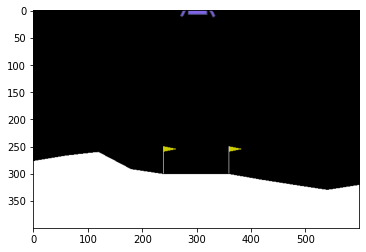

In [ ]:
env=create_environment('LunarLander-v2')
env.reset()
#testing
env.observation_space.sample()
env.action_space.sample()
print("action_space_n=",env.action_space.n)

import matplotlib.pyplot as plt
plt.imshow(env.render(mode='rgb_array'))

##2.6 Create the test/sampling function

In [ ]:
purge=1
if purge:
  !rm -r /content/lightning_logs-1/
  !rm -r /content/videos-1/

rm: cannot remove '/content/lightning_logs/': No such file or directory


In [ ]:
env2=create_environment('LunarLander-v2')
epochs=2
for episode in range(epochs):
  env2.reset()
  print('*',end="")
  done = False
  while not done:
    action=env2.action_space.sample()
    _,_,done,_, =env2.step(action)

**

In [ ]:
display_video(episode=0)

##2.7 Create the Deep Q-Learning algorithm

In [ ]:
class DeepQLearning(LightningModule):

  #initialize
  def __init__(self, env_name, policy=epsilon_greedy, capacity=100_000, batch_size=256,lr=1e-3, 
          hidden_size=128,gamma=0.99,loss_fn=F.smooth_l1_loss, optim=AdamW, 
          eps_start=1.0,eps_end=0.15,eps_last_episode=100,samples_per_epoch=10_000,sync_rate=10):
    
    super().__init__()
    self.env=create_environment(env_name)

    obs_size= self.env.observation_space.shape[0]
    n_actions=self.env.action_space.n

    self.q_net=DQN(hidden_size,obs_size,n_actions)

    self.target_q_net= copy.deepcopy(self.q_net)

    self.policy =policy
    self.buffer=ReplayBuffer(capacity=capacity)
    self.save_hyperparameters()

    while len(self.buffer)<self.hparams.samples_per_epoch:
      print(f"{len(self.buffer)} samples in expereience buffer. Filling ...")
      self.play_episode(epsilon=self.hparams.eps_start)

  @torch.no_grad()
  def play_episode(self, policy=None, epsilon=0.):
    state= self.env.reset()
    done=False
      
    while not done:
      if policy:
        action=policy(state, self.env, self.q_net,epsilon=epsilon)
      else:
        action=self.env.action_space.sample()
      
      next_state, reward, done, info=self.env.step(action)
      exp = (state, action, reward,done,next_state)
      self.buffer.append(exp)
      state=next_state

  #Forward path
  def forward(self, x):
    return self.q_net(x)

  #Config optimumizer
  def configure_optimizers(self):
    q_net_optimizer=self.hparams.optim(self.q_net.parameters(),lr=self.hparams.lr)
    return [q_net_optimizer]

  #prepare training state using data loader
  def train_dataloader(self):
    dataset=RLDataset(self.buffer, self.hparams.samples_per_epoch)
    dataloader=DataLoader(dataset=dataset,batch_size=self.hparams.batch_size)
    return dataloader

  # training step
  def training_step(self,batch,batch_idx):
    states, actions,rewards,dones, next_states = batch
    actions = actions.unsqueeze(1)
    rewards = rewards.unsqueeze(1)
    dones= dones.unsqueeze(1)
    #next_states = next_states.unsqueeze(1)

    state_action_values=self.q_net(states).gather(1, actions)
    next_action_values, _ =self.target_q_net(next_states).max(dim=1,keepdim=True)
    next_action_values[dones]= 0.0

    expected_state_action_values = rewards+ self.hparams.gamma*next_action_values
    loss=self.hparams.loss_fn(state_action_values, expected_state_action_values)
    self.log('episode/Q-Error',loss)
    return loss

  #training end 
  def training_epoch_end(self, training_step_outputs):

    epsilon= max(
      self.hparams.eps_end,
      self.hparams.eps_start-self.current_epoch/self.hparams.eps_last_episode
    )
    self.play_episode(policy=self.policy, epsilon=epsilon)
    self.log('episode/Return', self.env.return_queue[-1])

    if self.current_epoch % self.hparams.sync_rate==0:
      self.target_q_net.load_state_dict(self.q_net.state_dict())

##2.8 Purge logs and run the visualization tool (Tensorboard)

In [ ]:
#執行階段類型須選擇GPU否則不會有值
!rm -r /content/lightning_logs-1/
!rm -r /content/videos-1/
%load_ext tensorboard
# %reload_ext tensorboard

# %tensorboard --logdir /content/lightning_logs-1/ --bind_all

%tensorboard --logdir /content/lightning_logs-1/ --bind_all



##Train the policy

In [ ]:
algo = DeepQLearning('LunarLander-v2')
trainer= Trainer(
    gpus=num_gpus,
    max_epochs=10_000,
    callbacks=[EarlyStopping(monitor='episode/Return',mode='max', patience=500)]
)
trainer.fit(algo)

0 samples in expereience buffer. Filling ...
84 samples in expereience buffer. Filling ...
181 samples in expereience buffer. Filling ...
258 samples in expereience buffer. Filling ...
374 samples in expereience buffer. Filling ...
511 samples in expereience buffer. Filling ...
593 samples in expereience buffer. Filling ...
707 samples in expereience buffer. Filling ...
798 samples in expereience buffer. Filling ...
885 samples in expereience buffer. Filling ...
979 samples in expereience buffer. Filling ...
1065 samples in expereience buffer. Filling ...
1187 samples in expereience buffer. Filling ...
1310 samples in expereience buffer. Filling ...
1378 samples in expereience buffer. Filling ...
1469 samples in expereience buffer. Filling ...
1538 samples in expereience buffer. Filling ...
1610 samples in expereience buffer. Filling ...
1719 samples in expereience buffer. Filling ...
1786 samples in expereience buffer. Filling ...
1852 samples in expereience buffer. Filling ...
1928 s

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /content/lightning_logs

  | Name         | Type | Params
--------------------------------------
0 | q_net        | DQN  | 18.2 K
1 | target_q_net | DQN  | 18.2 K
--------------------------------------
36.4 K    Trainable params
0         Non-trainable params
36.4 K    Total params
0.145     Total estimated model params size (MB)


9635 samples in expereience buffer. Filling ...
9712 samples in expereience buffer. Filling ...
9786 samples in expereience buffer. Filling ...
9903 samples in expereience buffer. Filling ...
9995 samples in expereience buffer. Filling ...


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  """


##Check the resulting policy

In [ ]:
display_video(episode=1000)

In [ ]:
# %cp -av "/content/lightning_logs-1" "/content/drive/MyDrive/Colab Notebooks/HW5/"

In [ ]:
# %cp -av "/content/sample_data-1" "/content/drive/MyDrive/Colab Notebooks/HW5/"

In [ ]:
# %cp -av "/content/videos-1" "/content/drive/MyDrive/Colab Notebooks/HW5/"